In [117]:
import wandb
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

api = wandb.Api()
runs = api.runs("apjacob/adapt-minirts", per_page=50)

results = []
fixed_merged_result_dict = {}
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config

    if "max_iterations" not in summary:
        continue

    if summary["max_iterations"] > 1500 and (config["rule"] == 80 or config["rule"] == 3):
        coach = config["coach1"]
        lr = config["lr"]
        cur_executor1 = config["executor1"]
        cur_train_mode = config["train_mode"]
        cur_rule = config["rule"]
        
        data = run.history()
        if cur_train_mode == "coach" and cur_executor1 == "rnn" and lr == 3e-6 and cur_rule==80:
            key = "ft_coach[80]"
        elif cur_train_mode == "executor" and cur_executor1 == "zero" and lr == 7e-6 and cur_rule==80:
            key = "ft_zero[80]"
        elif cur_train_mode == "executor" and cur_executor1 == "rnn" and lr == 5e-6 and cur_rule==80:
            key = "ft_hier_exec[80]"
        elif cur_train_mode == "both" and cur_executor1 == "rnn" and lr == 6e-6 and cur_rule==80:
            key = "ft_both[80]"
        elif cur_train_mode == "both" and cur_executor1 == "rnn" and lr == 6e-6 and cur_rule==3:
            key = "ft_both[3]"
        else:
            continue

        l = fixed_merged_result_dict.get(key, [])
        point = data[["_step", "Train/Agent-1/Win"]]
        l.append(point)
        fixed_merged_result_dict[key] = l

        id = run.id
        name = run.name
        entry = {**summary, **config, "ID": id, "Name": name}
        results.append(entry)

100%|██████████| 457/457 [01:38<00:00,  4.63it/s]


In [120]:
runs = api.runs("apjacob/adapt-minirts-pop", per_page=50)

results = []
pop_merged_result_dict = {}
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config

    if "max_iterations" not in summary:
        continue

    if summary["max_iterations"] > 1500 and (config["rule_series"] == ["80", "40", "20"] or 
                                             config["rule_series"] == ["3", "12", "13"]) :
        coach = config["coach1"]
        lr = config["lr"]
        cur_executor1 = config["executor1"]
        cur_train_mode = config["train_mode"]
        
        data = run.history()
        
        if config["rule_series"] == ["80", "40", "20"]:
            key = "ft_pop[80,40,20]"
            entry = "Train/Agent-1_80/Win"
        elif config["rule_series"] == ["3", "12", "13"]:
            key = "ft_pop[3,12,13]"
            entry = "Train/Agent-1_3/Win"
        else:
            raise KeyError

        l = pop_merged_result_dict.get(key, [])
        point = data[["_step", entry]]
        l.append(point)
        pop_merged_result_dict[key] = l

        id = run.id
        name = run.name
        entry = {**summary, **config, "ID": id, "Name": name}
        results.append(entry)

100%|██████████| 66/66 [00:10<00:00,  6.32it/s]


In [57]:
# p1 = merged_result_dict["ft_coach[80]"][0]
# p2 = merged_result_dict["ft_coach[80]"][1]
# 
# d = pd.concat(merged_result_dict["ft_coach[80]"]).groupby("_step")["Train/Agent-1/Win"].agg(["min", "max", "mean"])
# d.reset_index(inplace=True)
# 
# ax  = d.plot(x='_step', y='mean', c='black')
# plt.fill_between(x='_step',y1='min',y2='max', data=d, color='red')
# plt.show()


In [58]:
# from functools import reduce
# 
# main_df = reduce(lambda df1, df2: df1.merge(df2, on="_step", how="outer"), merged_result_dict["ft_both[80]"])
# main_df.columns = ["_step"] + ["ft_both[80]"] * 2 + ["ft_both[80]_2"] * (len(merged_result_dict["ft_both[80]"])-2)
# sns.lineplot(
#     data=main_df.set_index("_step"),
#     ci="sd",   
# )
# 
# 
# plt.show()


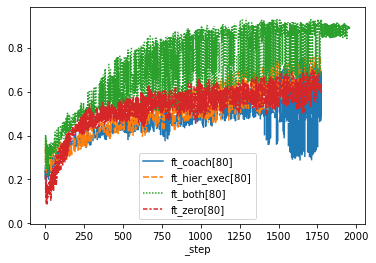

In [112]:
from functools import reduce

columns = ['_step']
main_list = []
for key, l in fixed_merged_result_dict.items():
    l = [x.dropna() for x in l]
    l = [x.ewm(alpha=0.1).mean() for x in l]
    columns += [key]*len(l)
    main_list += l


main_df = reduce(lambda df1, df2: df1.merge(df2, on="_step", how="outer"), main_list)
main_df.columns = columns
sns.lineplot(
    data=main_df.set_index("_step"),
    ci=None
)
plt.show()

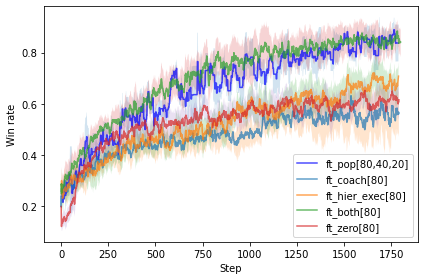

In [192]:
plt.clf()
alpha = 0.1

pop_df = pd.concat(pop_merged_result_dict["ft_pop[80,40,20]"])
pop_df = pop_df.groupby("_step")["Train/Agent-1_80/Win"].agg(["mean", "sem"])
pop_df.reset_index(inplace=True)
pop_df.dropna()
pop_df = pop_df.ewm(alpha=alpha).mean()
plt.plot("_step", "mean", c="blue", alpha=0.7, label="ft_pop[80,40,20]", data=pop_df)
plt.fill_between(pop_df["_step"], pop_df["mean"] - pop_df["sem"] , pop_df["mean"] + pop_df["sem"], alpha=0.2)

for k, v in fixed_merged_result_dict.items():
    if k == "ft_both[3]":
        continue

    main_df = pd.concat(v)
    main_df = main_df.groupby("_step")["Train/Agent-1/Win"].agg(["mean", "sem"])
    main_df.reset_index(inplace=True)
    main_df = main_df.ewm(alpha=alpha).mean()
    main_df = main_df[main_df["_step"] <= 1800]
    plt.plot("_step", "mean", alpha=0.7, label=k, data=main_df)
    plt.fill_between(main_df["_step"], main_df["mean"] - main_df["sem"] , main_df["mean"] + main_df["sem"], alpha=0.2)


plt.legend()
plt.xlabel('Step')
plt.ylabel('Win rate')
plt.tight_layout()
plt.savefig("comp_80.png", dpi=500)
plt.show()

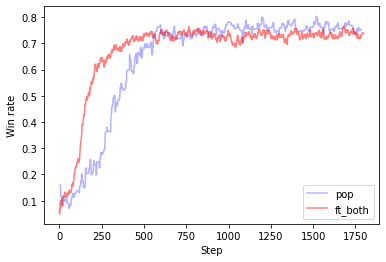

In [125]:
plt.clf()
# columns = ['_step']
# main_list = []
# 
# # columns += ["ft_both[80]"]*len(fixed_merged_result_dict["ft_both[80]"])
# # main_list += fixed_merged_result_dict["ft_both[80]"]
# columns += ["ft_pop[80,40,20]"]*len(pop_merged_result_dict["ft_pop[80,40,20]"])
# main_list += pop_merged_result_dict["ft_pop[80,40,20]"]
# 
# main_df = reduce(lambda df1, df2: df1.merge(df2, on="_step", how="outer"), main_list)    
# main_df.columns = columns

main_df = pd.concat(pop_merged_result_dict["ft_pop[3,12,13]"])

# min_df = main_df.groupby("_step")["Train/Agent-1_80/Win"].agg(["min"]).rename(columns={'Train/Agent-1_80/Win': 'min'})
# max_df = main_df.groupby("_step")["Train/Agent-1_80/Win"].agg(["max"]).rename(columns={'Train/Agent-1_80/Win': 'max'})
mean_df = main_df.groupby("_step")["Train/Agent-1_3/Win"].agg(["mean"]).rename(columns={'Train/Agent-1_3/Win': 'mean'})

# min_df.reset_index(inplace=True)
# max_df.reset_index(inplace=True)
mean_df.reset_index(inplace=True)

# min_df.dropna(inplace=True)
# max_df.dropna(inplace=True)
mean_df = mean_df.ewm(alpha=0.1).mean()

# main_df.set_index("_step").plot()

# ax  = main_2.plot(x='_step', y='mean', c='black')
# plt.fill_between(x='_step',y1='min',y2='max', data=main_2, color='red')
# 
# ax = max_df.plot(x="_step", y="max", label='Max Recorded', color='tab:red')
# min_df.plot(ax=ax, label='Min Recorded', color='tab:blue')
# 
# # add the fill, between min and max
# plt.fill_between(max_14.index, max_14.Daily_Max, min_14.Daily_Min, alpha=0.10, color='tab:orange')
# 

main_df = pd.concat(fixed_merged_result_dict["ft_both[3]"])

# min_df = main_df.groupby("_step")["Train/Agent-1_80/Win"].agg(["min"]).rename(columns={'Train/Agent-1_80/Win': 'min'})
# max_df = main_df.groupby("_step")["Train/Agent-1_80/Win"].agg(["max"]).rename(columns={'Train/Agent-1_80/Win': 'max'})
mean_df_2 = main_df.groupby("_step")["Train/Agent-1/Win"].agg(["mean"]).rename(columns={'Train/Agent-1/Win': 'mean'})
mean_df_2.reset_index(inplace=True)
mean_df_2 = mean_df_2.ewm(alpha=0.1).mean()
mean_df_2 = mean_df_2[mean_df_2["_step"] <= 1800]
# ax = plt.plot(max_df["_step"], max_df["max"], c="r", alpha=0.5,
#             label="min")
# plt.plot(min_df["_step"], min_df["min"], c="g", alpha=0.5,
#             label="min")
plt.plot("_step", "mean", c="blue", alpha=0.3,
            label="pop", data=mean_df)
plt.plot("_step", "mean", c="red", alpha=0.5,
            label="ft_both", data=mean_df_2)
plt.legend()
# plt.scatter(max_df["_step"], max_df["max"], c="r", alpha=0.5,
#             label="max")
# plt.plot(mean_df["_step"], mean_df["mean"], c="b", alpha=0.5,
#             label="mean")

# sns.lineplot(
#     data=main_df.set_index("_step"),
# )
plt.xlabel('Step')
plt.ylabel('Win rate')
plt.savefig("comp_3.png", dpi=300)
plt.show()

